In [1386]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
import sklearn as skl
import numpy as np
import pandas as pd
import seaborn as sns
import re
import os

STOPWORDS = set(stopwords.words('english'))
STEMMER = PorterStemmer()

In [1387]:
old_data = pd.read_csv("Davidson&al.csv")
old_data

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [1388]:
old_data = pd.concat([old_data["class"], old_data["tweet"]], axis=1)

In [1389]:
old_data.replace({0: "hate speech", 1: "offensive language", 2: "normal"}, inplace=True)

In [1390]:
old_data[old_data["tweet"].str.contains("http")]

,class,tweet
24,offensive language,""" got ya bitch tip toeing on my hardwood floor..."
41,offensive language,""" most hated but the hoes favorite "" #2MW #Sev..."
42,offensive language,""" nice girls bad, make me get naughty. Bad yel..."
45,offensive language,""" pussy is a powerful drug "" &#128517; #HappyH..."
62,offensive language,"""@ARIZZLEINDACUT: Females think dating a pussy..."
...,...,...
25191,offensive language,when you first walked in the door at that part...
25234,normal,wth is that playing missy? ........ i mean ser...
25252,offensive language,yeah I'm small den a hoe http://t.co/VV3qdTo7MG
25276,offensive language,you gotta be a new breed of retarded if you do...


In [1391]:
data

,class,tweet
0,normal,woman complain clean hous man alway take trash
40,normal,momma said pussi cat insid doghous
63,normal,simplyaddictedtoguy woof woof hot scalli lad
66,normal,woof woof hot sole
67,normal,lemmi eat oreo dish one oreo lol
...,...,...
13963,offensive language,hello hardin counti everyon know hoe name ashl...
4722,offensive language,say would beat like bitch put foot neck shoot
20329,offensive language,u bitch pay bill fuck
10234,offensive language,hypocrit littl bitch


In [1392]:
def sanitize_tweet(tweet):
    text = re.sub("\"+", "", tweet)
    text = re.sub("\s+", " ", text)
    text = re.sub("RT", "", text)
    text = re.sub("https?:?/?/?[^\s]+", "", text)
    text = re.sub("&#[0-9]+;", "", text)
    text = re.sub("&.+;", "", text)
    tknzr = TweetTokenizer(preserve_case=False, strip_handles=True)
    text = " ".join([STEMMER.stem(s) for s in tknzr.tokenize(text) if s.isalpha() and s not in STOPWORDS])
    return text

In [1393]:
old_data["tweet"] = old_data["tweet"].apply(sanitize_tweet)

In [1394]:
old_data[old_data["tweet"].str.contains("http")]

,class,tweet


In [1395]:
data

,class,tweet
0,normal,woman complain clean hous man alway take trash
40,normal,momma said pussi cat insid doghous
63,normal,simplyaddictedtoguy woof woof hot scalli lad
66,normal,woof woof hot sole
67,normal,lemmi eat oreo dish one oreo lol
...,...,...
13963,offensive language,hello hardin counti everyon know hoe name ashl...
4722,offensive language,say would beat like bitch put foot neck shoot
20329,offensive language,u bitch pay bill fuck
10234,offensive language,hypocrit littl bitch


In [1396]:
old_data.loc[58,:,].tolist()

['offensive language', 'son bitch took tic tac like movi']

In [1397]:
ol = old_data.loc[old_data['class'] == "offensive language"]
old_ol = shuffle(ol)
ol = old_ol[:4000]

rest = data.loc[old_data['class'] != "offensive language"]
rest = rest.append(ol)
data = rest

In [1398]:
clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier()),])
clf = clf.fit(data["tweet"], data["class"])

In [1399]:
docs_new = ["Hey, panini head! Are you listening?", "You're an idiot sandwich", "Fuck off you fat useless sack of fucking yankee dankee doodle shite", "You surprise me as to how bad you are", "Fuck off! Fuck off! Fuck off! Fuck off!", "You guys cook like old people.", "There’s enough garlic in here to kill every vampire in Europe.", "This soufflé has sunk so badly James Cameron wants to make a film about it.", "He cant's count to fucking two!", "You deserve a kick in the nuts", "You look like you're just about to lose your virginity.", "You're a fucking disgrace"]
docs_new_sanitized = [sanitize_tweet(s) for s in docs_new]
predicted = clf.predict(docs_new_sanitized)
for x,y in zip(docs_new, predicted):
    print(x, "->", y)

Hey, panini head! Are you listening? -> normal
You're an idiot sandwich -> normal
Fuck off you fat useless sack of fucking yankee dankee doodle shite -> hate speech
You surprise me as to how bad you are -> normal
Fuck off! Fuck off! Fuck off! Fuck off! -> offensive language
You guys cook like old people. -> normal
There’s enough garlic in here to kill every vampire in Europe. -> normal
This soufflé has sunk so badly James Cameron wants to make a film about it. -> normal
He cant's count to fucking two! -> hate speech
You deserve a kick in the nuts -> normal
You look like you're just about to lose your virginity. -> normal
You're a fucking disgrace -> hate speech


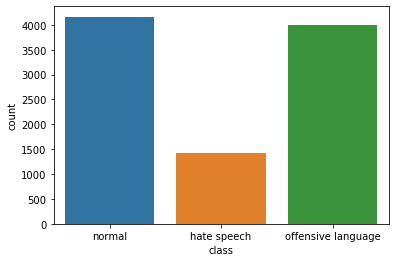

In [1400]:
sns.countplot(x="class", data=data)

In [1401]:
print(metrics.classification_report(data["class"], clf.predict(data["tweet"])))

                    precision    recall  f1-score   support

       hate speech       0.88      0.66      0.75      1430
            normal       0.93      0.99      0.96      4163
offensive language       0.90      0.93      0.92      4000

          accuracy                           0.91      9593
         macro avg       0.90      0.86      0.88      9593
      weighted avg       0.91      0.91      0.91      9593



In [1402]:
print(metrics.classification_report(old_ol["class"], clf.predict(old_ol["tweet"])))

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                    precision    recall  f1-score   support

       hate speech       0.00      0.00      0.00         0
            normal       0.00      0.00      0.00         0
offensive language       1.00      0.88      0.94     19190

          accuracy                           0.88     19190
         macro avg       0.33      0.29      0.31     19190
      weighted avg       1.00      0.88      0.94     19190



In [1403]:
print(metrics.classification_report(old_data["class"], clf.predict(old_data["tweet"])))

                    precision    recall  f1-score   support

       hate speech       0.48      0.66      0.56      1430
            normal       0.74      0.99      0.85      4163
offensive language       0.98      0.88      0.93     19190

          accuracy                           0.89     24783
         macro avg       0.73      0.84      0.78     24783
      weighted avg       0.91      0.89      0.89     24783

